O que faremos com todas essas estatísticas e teoria das probabilidades? A parte científica da ciência de dados frequentemente envolve a formação e teste de hipóteses sobre nossos dados e os processos que os geram.

# Testes estatísticos de hipóteses

Muitas vezes, como cientistas de dados, queremos testar se uma certa hipótese provavelmente será verdadeira. Para nossos propósitos, hipóteses são afirmações como "esta moeda é justa" ou "cientistas de dados preferem Python a R" ou "as pessoas tendem a navegar para fora da página sem nunca ler o conteúdo se aparecer um anúncio intersticial irritante com um botão de fechar minúsculo e difícil de encontrar" que podem ser traduzidas em estatísticas sobre dados. Sob várias suposições, essas estatísticas podem ser consideradas como observações de variáveis aleatórias de distribuições conhecidas, o que nos permite fazer afirmações sobre a probabilidade dessas suposições serem mantidas.

Na configuração clássica, temos uma hipótese nula $H_0$ que representa alguma posição padrão e alguma hipótese alternativa $H_1$ com a qual gostaríamos de compará-la. Usamos estatísticas para decidir se podemos rejeitar $H_0$ como falsa ou não. Isso provavelmente fará mais sentido com um exemplo.

## Exemplo: lançando uma moeda

Imagine que temos uma moeda e queremos testar se ela é justa. Vamos supor que a moeda tem alguma probabilidade $p$ de dar "cara" e, portanto, nossa hipótese nula é que a moeda é justa - isto é, que $p = 0.5$. Vamos testar isso contra a hipótese alternativa $p \neq 0.5$.

Em particular, nosso teste envolverá lançar a moeda um número $n$ de vezes e contar o número de caras $X$. Cada lançamento de moeda é um teste de Bernoulli, o que significa que $X$ é uma variável aleatória Binomial($n, p$) que, como vimos, pode ser aproximada usando a distribuição normal:

In [1]:
import math

def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Com essa função, podemos calcular rapidamente os parâmetros da aproximação normal a partir dos parâmetros $n$ e $p$ da distribuição binomial. 

Considere, por exemplo, que a moeda vai ser jogada 1000 vezes e que a moeda é justa, ou seja, $p=0.5$:

In [2]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


Podemos agora plotar as funções __PDF__ e __CDF__ da distribuição normal dos parâmetros `mu` e `sigma` acima calculados. Para isso, podemos usar as funções que implementamos na aula anterior ou então aquelas disponíveis no módulo [`scipy.stats.norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). 

In [3]:
from scipy.stats import norm
from matplotlib import pyplot as plt

In [4]:
matplotlib inline

Como a média é $1000 \times 0.5 = 500$, vamos definir nosso domínio ao redor desse valor:

In [5]:
xs = [x / 1.0 for x in range(400, 600)]

Primeiro, vamos plotar a funçao __PDF__ a partir da função `norm.pdf`:

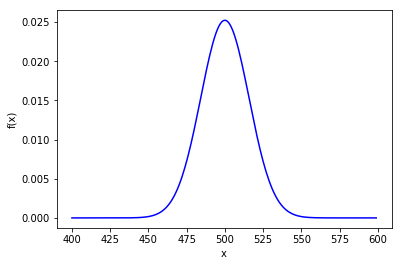

In [6]:
fig = plt.figure()
plt.plot(xs,[norm.pdf(x,mu_0, sigma_0) for x in xs],'b-')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()
fig.savefig("normalpdf-1000-0_5.png")

Agora, vamos plotar a funçao __CDF__ a partir da função `norm.cdf`:

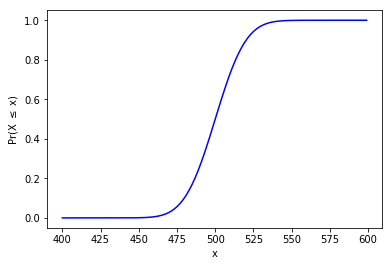

In [7]:
fig = plt.figure()
plt.plot(xs,[norm.cdf(x,mu_0, sigma_0) for x in xs],'b-')
plt.ylabel('Pr(X $\leq$ x)')
plt.xlabel('x')
plt.show()
fig.savefig("normalcdf-1000-0_5.png")

Sempre que uma variável aleatória segue uma distribuição normal, podemos usar a CDF dessa distribuição para descobrir a probabilidade de seu valor realizado estar dentro ou fora de um intervalo específico (observe que usaremos a função `norm.cdf` do `scipy.stats`, que funciona como a função `normal_cdf` que implementamos anteriormente):

In [8]:
# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = norm.cdf

# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - norm.cdf(lo, mu, sigma)

# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return norm.cdf(hi, mu, sigma) - norm.cdf(lo, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

Também podemos fazer o inverso - encontrar o intervalo (simétrico) em torno da média que representa um certo nível de probabilidade. Por exemplo, se quisermos encontrar um intervalo centrado na média e contendo 60% de probabilidade, então encontramos os pontos de corte onde cada uma das caudas superior e inferior contém 20% da probabilidade (deixando 60%).

Nos exemplos abaixo, também usaremos a função uma função pronta, a `norm.isf` do `scipy.stats`. Embora não seja equivalente a função `inverse_normal_cdf` que implementamos anteriormente, ela serve para a mesma função se usarmos o complemento `1-p` da probabilidade `p`. Enquanto `inverse_normal_cdf` retorna o inverso da CDF (ou $P(X \leq x)$, a função `norm.isf` retorna o inverso da função de sobrevivência da normal, que é 1-CDF (ou P(X > x). Assim, se quisermos saber qual é o menor valor $x$ que é maior ou igual a $20\%$ dos valores da distribuição (`inverse_normal_cdf(0.2, mu, sigma)`) , basta encontrar o valor $x$ que é estritamente menor que $80\%$ dos valores da distribuição, ou `norm.isf(1-0.2, mu, sigma)`.

In [9]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return norm.isf(1-probability, mu, sigma)
    #return inverse_normal_cdf(probability, mu, sigma)
    
def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return norm.isf(probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

Em particular, suponha que vamos lançar uma moeda $n = 1000$ vezes. Se nossa hipótese de justiça for verdadeira, X deve ser distribuído aproximadamente normalmente com média de $500$ e desvio padrão de $15.8$:

In [10]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


Precisamos tomar uma decisão sobre a *significância*, que mede o quanto estamos dispostos a cometer um *erro do tipo 1* (“falso positivo”), no qual rejeitamos $H_0$, embora ela seja verdade. Por razões perdidas para os anais da história, essa disposição é muitas vezes definida em $5\%$ ou $1\%$. Vamos escolher $5\%$.

Considere o teste que rejeita $H_0$ se $X$ estiver fora dos limites dados por:

In [11]:
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lo, hi)

469.0102483847719 530.9897516152281


Os valores acima (`lo` e `hi`) indicam a região em que %95\%$ dos valores da distribuição normal com média `mu_0` e desvio padrão `sigma_0` estão.

Assumindo que $p$ é realmente igual a $0.5$ (ou seja, $H_0$ é verdade), há apenas $5\%$ de chance de observarmos um $X$ que está fora desse intervalo, que é o significado exato que queríamos. Dito de forma diferente, se $H_0$ for verdadeiro, então, aproximadamente $19$ vezes de $20$ este teste dará o resultado correto.

Também estamos frequentemente interessados no *poder* (ou *power*) de um teste, que é a probabilidade de não cometer um *erro do tipo 2*, em que não podemos rejeitar $H_0$, mesmo ela sendo falsa. Para medir isso, temos que especificar o que é exatamente $H_0$ ser falsa. (Saber apenas que $p$ não é $0.5$ não fornece muitas informações sobre a distribuição de $X$.) Em particular, vamos verificar o que acontece se $p$ for, na verdade, $0.55$, de modo que a moeda seja ligeiramente tendenciosa a dar "cara". Nesse caso, gostaríamos de rejeitar $H_0$.

Nesse caso, podemos calcular o poder do teste com:

In [12]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability 
print("type 2 probability: ", type_2_probability)
print("power:", power)

type 2 probability:  0.11345221890161725
power: 0.8865477810983827


As análises acima indicam que, quando a moeda for tendenciosa com $p=0.55$, $11.35\%$ das vezes a variável $X$ terá um valor dentro do intervalo $[lo, hi]$. Em outras palavras, $88.65\%$ das vezes o nosso teste vai rejeitar $H_0$ corretamente quando $p=0.55$.

Imagine agora a seguinte situação. Você está em uma disputa de "cara-e-cora" com um amigo e ele ganha quando a moeda der "cara" e você ganha quando der "coroa". O problema é que a moeda é dele, e você desconfia que a moeda é tendenciosa para dar "cara", ou seja, o seu problema não é se a moeda é tendenciosa, mas sim se a moeda é tendenciosa apenas para um dos lados ("cara").

Nesse caso, nossa hipótese nula $H_0$ é que a moeda não é tendenciosa a dar "cara", ou que $p \leq 0.5$. Queremos, então, um teste unilateral que rejeita a hipótese nula quando $X$ é muito maior que $500$, mas não quando $X$ é menor que $500$ (o nosso amigo não iria jogar com uma moeda tendenciosa para perder). Portanto, um teste de significância de $5\%$ envolve o uso de `normal_probability_below` para encontrar o ponto de corte abaixo do qual $95\%$ da probabilidade reside:

In [13]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print(hi)
# 526 < 531, since we need more probability in the upper tail

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
print(power)

526.0074193937779
0.936378997857743


No primeiro teste, rejeitávamos $H_0$ quando $X$ está fora do intervalo $[469,531]$. Este segundo é um teste mais poderoso, já que ele não rejeita mais $H_0$ quando $X$ está abaixo de $469$ (o que é muito improvável acontecer se $H_1$ for verdadeira) e rejeita $H_0$ quando $X$ está entre $526$ e $531$ (o que é provável que aconteça se $H_1$ for verdadeira) e, é claro, quando for maior que $531$.

Uma maneira alternativa de pensar sobre o teste anterior envolve *p-valores* (ou *p-values*). Em vez de escolher limites com base em algum corte de probabilidade, calculamos a probabilidade - assumindo que $H_0$ é verdadeira - de que veríamos um valor pelo menos tão extremo quanto o que realmente observamos.

Para nosso teste de dois lados de saber se a moeda é justa, calculamos:

In [14]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)

Note que multiplicamos as probabilidades por $2$ porque este é um teste de dois lados, ou seja, não sabemos se a "moeda" está tendenciosa para algum lado. 

Então, se por acaso, $1000$ lançamentos de moedas resultassem em $530$ "caras", podemos calcular o *p-valor* para $X=530$:

In [15]:
p_value = two_sided_p_value(529.5, mu_0, sigma_0)
print(p_value)

0.06207721579598835


Por que usamos $529.5$ em vez de $530$? Isso é o que é chamado de *correção de continuidade*. Isso reflete o fato de que `normal_probability between(529.5, 530.5, mu_0, sigma_0)` é uma estimativa melhor da probabilidade de ver $530$ "caras" do que a `normal_probability between(530, 531, mu_0, sigma_0)`.

Correspondentemente, `normal_probability_above(529.5, mu_0, sigma_0)` é uma estimativa melhor da probabilidade de ver pelo menos `530` "caras". 

Uma maneira de se convencer de que esta é uma estimativa sensata é com uma simulação:

In [16]:
import random

extreme_value_count = 0
for _ in range(100000): #100000 simulacoes
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads
                    for _ in range(1000))             # in 1000 flips
    if num_heads >= 530 or num_heads <= 470: # and count how often
        extreme_value_count += 1 # the # is 'extreme'
        
print(extreme_value_count / 100000)

0.06304


Note que o valor acima é muito parecido com o valor do *p-valor* calculado anteriormente. 

Como o *p-valor* é maior do que nossa significância de $5%$ (ou $0.05$), não rejeitamos a hipótese nula. Se, em vez disso, víssemos 532 "caras", o *p-valor* seria:

In [17]:
p_value = two_sided_p_value(531.5, mu_0, sigma_0)
print(p_value)

0.046345287837786575


que é menor que a significância de 5%, o que significa que rejeitaríamos a hipótese nula. É exatamente o mesmo teste de antes. É apenas uma maneira diferente de abordar as estatísticas.
Da mesma forma, teríamos:

In [18]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

Para nosso teste unilateral, se víssemos 525 "caras", calcularíamos:

In [19]:
p_value = upper_p_value(524.5, mu_0, sigma_0)
print(p_value)

0.06062885772582072


o que significa que não rejeitaríamos a hipótese nula. Se víssemos 527 "caras", o cálculo seria:

In [20]:
p_value = upper_p_value(526.5, mu_0, sigma_0)
print(p_value)

0.04686839508859242


e nós rejeitaríamos a hipótese nula.

Certifique-se de que seus dados estejam distribuídos normalmente antes de usar métodos como os anteriores, i.e., `normal_probability_above`, para calcular os *p-valores*. Os anais da ciência de dados ruins são preenchidos com exemplos de pessoas opinando que a chance de algum evento observado ocorrer aleatoriamente é de um em um milhão, quando o que eles realmente querem dizer é "a chance, assumindo que os dados são distribuídos normalmente", o que é bastante sem sentido se os dados não forem.
Existem vários testes estatísticos para a normalidade, mas até mesmo a plotagem dos dados é um bom começo.

## Intervalos de Confiança

Testamos hipóteses sobre o valor da probabilidade $p$ de dar "caras", que é um parâmetro desconhecido da distribuição "caras". Quando este é o caso, uma terceira abordagem é construir um intervalo de confiança em torno do valor observado do parâmetro.

Por exemplo, podemos estimar a probabilidade da moeda injusta observando o valor médio das variáveis de Bernoulli correspondentes a cada lançamento - $1$ se cara, $0$ se coroa. Se observarmos $525$ "caras" de $1000$ lançamentos, estimamos $p$ igual a $0.525$.

Quão confiantes podemos estar sobre esta estimativa? Bem, se soubéssemos o valor exato de $p$, o teorema central do limite nos diz que a média dessas variáveis de Bernoulli deve ser aproximadamente normal, com média $p$ e desvio padrão $\sqrt{p (1-p) / 1000}$. Aqui não conhecemos o valor de $p$, então podemos estimar:

In [21]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) 
print("estimativa: (mu = ", p_hat, ", sigma = ", sigma, ")")

estimativa: (mu =  0.525 , sigma =  0.015791611697353755 )


Isso não é inteiramente justificado, mas as pessoas parecem fazer isso de qualquer maneira. Usando a aproximação normal, concluímos que estamos "95% confiantes" de que o intervalo a seguir contém o parâmetro verdadeiro $p$:

In [22]:
ic = normal_two_sided_bounds(0.95, mu, sigma)
print(ic)

(0.4940490098153452, 0.5559509901846548)


Esta é uma afirmação sobre o intervalo, não sobre $p$. Você deve
entender isso como a afirmação de que se você repetisse a experiência muitas vezes, 95% das vezes o parâmetro "verdadeiro" (que é o mesmo a cada vez) estaria dentro do intervalo de confiança observado (que pode ser diferente a cada vez).

Em particular, não concluímos que a moeda é injusta, uma vez que $0.5$ cai dentro do nosso intervalo de confiança.

Se em vez disso tivéssemos visto 540 cabeças, teríamos:

In [23]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) 
print("estimativa: (mu = ", p_hat, ", sigma = ", sigma, ")")
ic = normal_two_sided_bounds(0.95, mu, sigma)
print(ic)

estimativa: (mu =  0.54 , sigma =  0.015760710643876435 )
(0.5091095747672452, 0.5708904252327549)


Aqui, a "moeda justa" não está no intervalo de confiança. A hipótese da "moeda justa" não passa em um teste que você esperaria que passasse 95% do tempo, se fosse verdade.

## *P-hacking*

Um procedimento que erroneamente rejeita a hipótese nula apenas 5% do tempo irá, por definição, 5% do tempo erroneamente rejeitar a hipótese nula:

In [24]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

In [25]:
def reject_fairness(experiment, lb, ub):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < lb or num_heads > ub

In [26]:
def reject_fairness2(experiment, mu_0, sigma_0):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    p_value = two_sided_p_value(num_heads, mu_0, sigma_0)
    return p_value < 0.05

In [27]:
random.seed(0)
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print("rejeitamos o experimento se o # de caras",
      "estiver fora do intervalo",
      "[",lo,",",hi,"]")
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment for experiment in experiments
                      if reject_fairness(experiment, lo, hi)])
                      #if reject_fairness2(experiment, mu_0, sigma_0)])

print("numero de rejeicoes: ", num_rejections,
      "(", num_rejections/1000, ")")

rejeitamos o experimento se o # de caras estiver fora do intervalo [ 469.0102483847719 , 530.9897516152281 ]
numero de rejeicoes:  55 ( 0.055 )


O que isso significa é que, se você está procurando encontrar resultados "significativos", geralmente consegue. Teste hipóteses suficientes contra seu conjunto de dados, e um deles quase certamente parecerá significativo. Remova os *outliers* certos e provavelmente você poderá obter seu valor de $p$ abaixo de $0.05$. Ou seja, dos 1000 experimentos acima, 55 deles teriam um p-valor abaixo de $0.05$, indicando que a moeda não é justa. 

Às vezes, isso é chamado de [*p-hacking*](https://www.nature.com/news/scientific-method-statistical-errors-1.14700) e, de certa forma, é uma conseqüência da "inferência a partir de p-valores". Um bom artigo que critica essa abordagem é o [*The Earth is Round*](https://www.ics.uci.edu/~sternh/courses/210/cohen94_pval.pdf).

Se você quer fazer uma *boa ciência*, você deve determinar suas hipóteses antes de olhar os dados, você deve limpar seus dados sem as hipóteses em mente, e você deve ter em mente que p-valores não são substitutos do senso comum. (Uma abordagem alternativa é fazer "Inferência Bayesiana", que veremos a seguir.)

## Exemplo: executando um teste A / B

Uma de suas principais responsabilidades na *DataSciencester* é a otimização da experiência, que é um eufemismo para tentar fazer as pessoas clicarem em anúncios. Um de seus anunciantes desenvolveu uma nova bebida energética direcionada a cientistas de dados, e o vice-presidente de publicidade quer sua ajuda na escolha entre o anúncio $A$ ("o gosto é ótimo!") e o anúncio $B$ ("menos preconceito!").

Sendo um cientista, você decide realizar um experimento mostrando aleatoriamente aos visitantes do site um dos dois anúncios e acompanhando quantas pessoas clicam em cada um deles.

Se $990$ dos $1000$ visualizadores de $A$ clicarem no anúncio enquanto apenas $10$ dos $1000$ visualizadores de $B$ clicarem no anúncio, você poderá ter certeza de que $A$ é o melhor anúncio. Mas e se as diferenças não forem tão grandes? Aqui é onde você usa inferência estatística.

Digamos que $N_A$ pessoas veem o anúncio $A$ e que $n_A$ delas clicam nele. Podemos pensar em cada visualização de anúncio como uma teste de Bernoulli onde $p_A$ é a probabilidade de alguém clicar no anúncio $A$. Então (se $N_A$ é grande, que é o caso) sabemos que $n_A / N_A$ é aproximadamente uma variável aleatória normal com média $p_A$ e desvio padrão $\sigma_A = \sqrt{p_A(1 - p_A) / N_A}$.

Similarmente, $n_B / N_B$ é aproximadamente uma variável aleatória normal com média $p_B$ e desvio padrão $\sigma_B = \sqrt{p_B(1 - p_B) / N_B}$:

In [28]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

Se assumirmos que essas duas normais são independentes (o que parece razoável, já que os testes individuais de Bernoulli deveriam ser), então sua diferença também deveria ser normal com média $p_B - p_A$ e desvio padrão $\sqrt{\sigma_A^2 + \sigma_B^2}$.

Isso é uma espécie de trapaça. A matemática só funciona exatamente assim se você *souber* os desvios padrões. Aqui estamos estimando-os a partir dos dados, o que significa que deveríamos estar usando uma [*distribuição t*](https://en.wikipedia.org/wiki/Student%27s_t-distribution). Mas, para conjuntos de dados grandes o suficiente, estamos perto o suficiente para que não faça muita diferença.

Isso significa que podemos testar a hipótese nula de que $p_A$ e $p_B$ são os mesmos (isto é, que $p_A - p_B$ é zero), usando a seguinte estatística:

In [29]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

que deve ser aproximadamente normal.

Por exemplo, se "o gosto é ótimo" recebe $200$ cliques de $1000$ visualizações e "menos preconceito" recebe $180$ cliques de $1000$ visualizações, a estatística é igual a:

In [30]:
z = a_b_test_statistic(1000, 200, 1000, 180)
print(z)

-1.1403464899034472


A probabilidade de ver uma diferença tão grande se as médias fossem realmente iguais seria:

In [31]:
p = two_sided_p_value(z)
print(p)

0.254141976542236


que é grande o suficiente para que você não possa concluir que há muita diferença. Por outro lado, se "menos preconceito" tivesse apenas 150 cliques, teríamos:

In [32]:
z = a_b_test_statistic(1000, 200, 1000, 150) 
p = two_sided_p_value(z)

print("z = ", z)
print("probabilidade = ", p)

z =  -2.948839123097944
probabilidade =  0.0031896997062168583


o que significa que há apenas uma probabilidade de $0.003$ de vocês ver uma diferença tão grande quando os anúncios são igualmente eficazes

## Inferência Bayesiana

Os procedimentos que observamos envolveram declarações de probabilidade sobre nossos testes: "há apenas 3% de chance de você observar uma estatística tão extremada se nossa hipótese nula fosse verdadeira".

Uma abordagem alternativa de inferência envolve tratar os parâmetros desconhecidos como variáveis aleatórias. O analista (que é você) começa com uma *distribuição a priori* (*prior distribution*) para os parâmetros e, em seguida, usa os dados observados e o Teorema de Bayes para obter uma *distribuição a posteriori* (*posterior distribution*) atualizada para os parâmetros. Em vez de fazer julgamentos de probabilidade sobre os testes, você faz julgamentos de probabilidade sobre os próprios parâmetros.

Por exemplo, quando o parâmetro desconhecido é uma probabilidade (como em nosso exemplo de inversão de moeda), geralmente usamos um valor anterior da *distribuição Beta*, que coloca toda sua probabilidade entre $0$ e $1$. A sua PDF é dada por:

$$ f(x, \alpha, \beta) = \frac{x^{\alpha -1}(1-x)^{\beta -1}}{\mathrm {B} (\alpha ,\beta )}$$

em que

$$\mathrm {B} (\alpha ,\beta )={\frac {\Gamma (\alpha )\Gamma (\beta )}{\Gamma (\alpha +\beta )}}$$

e $\Gamma$ é a [função *Gamma*](https://en.wikipedia.org/wiki/Gamma_function), que é definida para um número positivo $n$ como:

$$\Gamma (n)=(n-1)!$$

A função beta, $\mathrm {B}$, é uma constante de normalização para assegurar que a probabilidade total integre a 1. Nas equações acima $x$ é uma realização - um valor observado que de fato ocorreu - de um processo aleatório $X$. Abaixo o código para a PDF da distribuição Beta:

In [33]:
def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:
        # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

De maneira geral, essa distribuição tem o seu peso centrado em $\alpha /( \alpha + \beta)$, ou `alpha /( alpha + beta)`.

Por exemplo, se $\alpha$ e $\beta$ são ambos 1, a distribuição é apenas a distribuição uniforme (centrada em $0.5$ e muito dispersa). Se $\alpha$ é muito maior que $\beta$, a maior parte da massa está próxima de 1. E se $\alpha$ é muito menor que $\beta$, a maior parte da massa está próxima de zero.

Então, vamos assumir uma distribuição a priori para $p$. Talvez não queiramos considerar se a moeda é justa, e escolhemos $\alpha = 1$ e $\beta = 1$. Ou talvez tenhamos uma forte crença de que "cara" caia $55\%$ das vezes, então escolhemos $\alpha = 55$ e $\beta = 45$.

Então, jogamos a moeda várias vezes e vemos $h$ "caras" e $t$ "coroas". O Teorema de Bayes (e [algumas contas matemáticas que são muito tediosas para nós passarmos aqui](https://en.wikipedia.org/wiki/Conjugate_prior)) nos diz que a distribuição a posteriori de $p$ é novamente uma distribuição Beta, mas com parâmetros $\alpha + h$ e $\beta + t$.

Não é por acaso que a distribuição a posteriori foi novamente uma distribuição Beta. O número de "caras" é dado por uma distribuição Binomial e a distribuição Beta é a [conjugada a priori](https://www.johndcook.com/blog/conjugate_prior_diagram/) à distribuição Binomial. Isto significa que sempre que você atualizar uma priori Beta antes usando observações de uma Binomial correspondente, você receberá uma Beta a posteriori.

Digamos que você jogue uma moeda 10 vezes e veja apenas 3 "caras".

Se você começou com uma a priori uniforme (em algum sentido, recusando-se a se posicionar sobre a justiça da moeda), sua distribuição a posteriori seria uma Beta $(\alpha = 1 + 3 = 4, \beta = 1 + 7 = 8)$, centrada em torno de $0.33$. Como você considerou todas as probabilidades igualmente prováveis, seu melhor palpite é algo bem próximo da probabilidade observada.

Se você começou com uma Beta $(\alpha = 20, \beta = 20)$ (expressando a crença de que a moeda era razoavelmente justa), sua distribuição posterior seria um Beta $(\alpha = 20 + 3 = 23, \beta = 20 + 7 = 27)$, centrada em torno de $0.46$, indicando uma crença revisada de que talvez a moeda seja levemente inclinada para as caudas.

E se você começou com uma Beta $(\alpha=30, \alpha=10)$ (expressando a crença de que a moeda era tendenciosa para dar "cara" $75\%$ das vezes), sua distribuição posterior seria um Beta $(\alpha = 30 + 3 = 33, \beta = 10 + 7 = 17)$, centrada em torno de $0.66$. Nesse caso, você ainda acredita em um viés para dar "cara", mas menos forte do que inicialmente.

Se você virasse a moeda mais e mais vezes, a priori importaria cada vez menos até que você teria (quase) a mesma distribuição posteriori, não importando qual priori foi usada.

Por exemplo, não importa quão tendenciosa você tenha pensado que a moeda era, seria difícil manter essa crença depois de ver 1000 "caras" de 2000 lançamentos (a menos que você seja um lunático que escolha uma priori como uma Beta $(\alpha=1000000, \beta=1)$).

O que é interessante é que isso nos permite fazer afirmações de probabilidade sobre hipóteses: "Com base nos dados anteriores e observados, há apenas uma probabilidade de 5% de que a probabilidade da moeda dar 'cara' esteja entre $49\%$ e $51\%$." Isto é filosoficamente muito diferente de uma declaração como "se a moeda fosse justa, esperaríamos observar dados tão extremos em apenas 5% do tempo".

Usar a inferência bayesiana para testar hipóteses é considerado um tanto controverso - em parte porque sua matemática pode ser um pouco complicada, e em parte por causa da natureza subjetiva da escolha de uma priori. Não vamos usá-la mais neste curso, mas é bom saber sobre.

## Para maior exploração

* Nós mal arranhamos a superfície do que você deveria saber sobre inferência estatística. Os livros recomendados no final da aula anterior entram em muito mais detalhes.

* O Coursera oferece um [curso de Análise de Dados e Inferência Estatística](https://www.coursera.org/specializations/statistics) que abrange muitos desses tópicos.

# Rascunho

In [34]:
from matplotlib import pyplot as plt

In [35]:
matplotlib inline

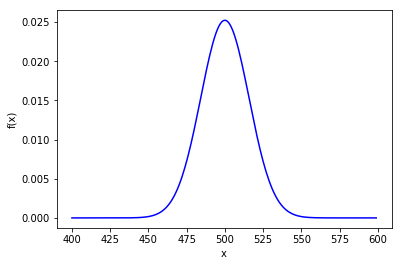

In [36]:
mu, sigma = normal_approximation_to_binomial(1000, 0.5)
xs = [x / 1.0 for x in range(400, 600)]
fig = plt.figure()
plt.plot(xs,[norm.pdf(x,mu, sigma) for x in xs],'b-')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()
fig.savefig("normalpdf-1000-0_5.png")

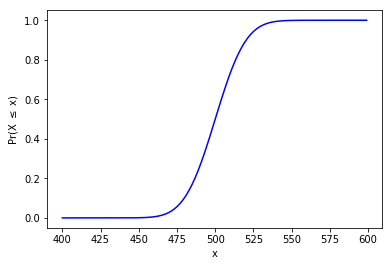

In [37]:
plt.plot(xs,[norm.cdf(x,mu, sigma) for x in xs],'b-')
plt.ylabel('Pr(X $\leq$ x)')
plt.xlabel('x')
plt.show()
fig.savefig("normalcdf-1000-0_5.png")

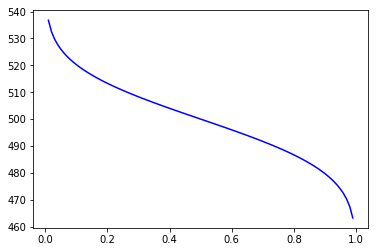

In [38]:
probs = [x / 100.0 for x in range(0, 100)]
plt.plot(probs,norm.isf(probs,mu,sigma),'b-')
#plt.ylabel('Pr(X $\leq$ x)')
#plt.xlabel('x')
plt.show()
#fig.savefig("normalcdf-1000-0_5.png")

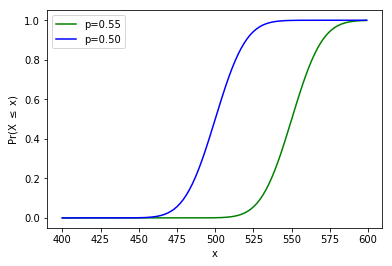

In [39]:
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
fig = plt.figure()
plt.plot(xs,[norm.cdf(x,mu_1, sigma_1) for x in xs],'g-', label='p=0.55')
plt.plot(xs,[norm.cdf(x,mu_0, sigma_0) for x in xs],'b-', label='p=0.50')
plt.ylabel('Pr(X $\leq$ x)')
plt.xlabel('x')
plt.legend(loc=2)
plt.show()
fig.savefig("normalcdf-1000-0_55vs0_50.png")

In [40]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

In [41]:
matplotlib inline

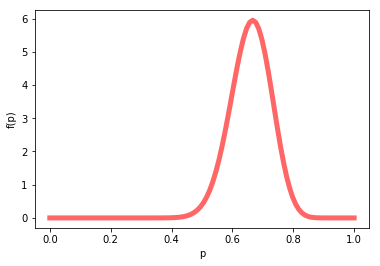

In [42]:
a, b = 33, 17
x = np.linspace(0,1, 100)
fig = plt.figure()
plt.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6)
plt.xlabel("p")
plt.ylabel("f(p)")
plt.show()
fig.savefig("beta33-17.png")

## Correlation p-value

In [43]:
import itertools
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from random import shuffle
from scipy.stats import norm

In [77]:
def tscore(v, df):
    return v*math.sqrt(df/(1.01-v*v))

In [45]:
def plotCorrHist(cvalues, size):
    fig = plt.figure()
    plt.hist(cvalues, density=True, bins=8, histtype='stepfilled', alpha=0.8)
    x = np.linspace(-1,1,100)
    mu = np.mean(cvalues)
    sigma = np.std(cvalues)
    plt.plot(x, norm.pdf(x, mu, sigma),'r-', lw=5, alpha=0.6, label='normal pdf')
    plt.xlabel("correlation")
    plt.ylabel("density")
    plt.legend(loc=2)
    plt.title('vector size: ' + str(size))
    plt.show()
    fig.savefig('histcorr' + str(size) + '.png')

In [46]:
def pvalor_correlacao_twosided(n, cvalue):
    if n > 7:
        return None, None
    cvalue = cvalue - 0.0000000001
    X = list(range(n))
    pX = list(itertools.permutations(X))
    c = np.corrcoef(pX)
    count = np.sum(abs(c) > abs(cvalue))
    total = c.shape[0] * c.shape[1]
    return count/total, c

0.034126984126984124


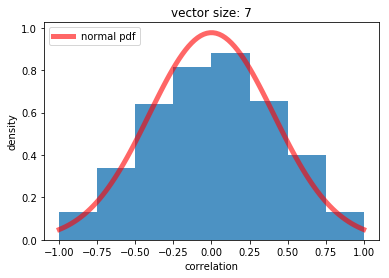

In [47]:
size = 7
p, c = pvalor_correlacao_twosided(size,0.8)
print(p)
cvalues = c.flatten()
plotCorrHist(cvalues, size)

In [48]:
cvalues = [tscore(v, size-2) for v in cvalues]

In [49]:
cvalues = c.flatten()
cvalues.shape

(25401600,)

In [50]:
import numpy as np
import math

In [51]:
def pvalor_correlacao_twosided(vector_size, rho):
    nrows = 2000
    s = np.random.normal(0, 1, (nrows, vector_size))
    c = np.corrcoef(s)
    count = np.sum(abs(c) >= abs(rho))
    total = nrows * nrows
    return count/total, c

In [90]:
size = 10
p, c = pvalor_correlacao_twosided(size, 0.99)
print("p-valor:", p)

p-valor: 0.0005


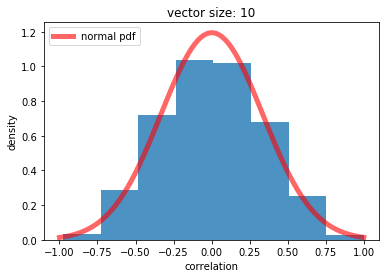

In [53]:
cvalues = c.flatten()
plotCorrHist(cvalues, size)

In [54]:
cvalues = [tscore(v, size-2) for v in cvalues if abs(v) < 0.99]
#cvalues = [v*math.sqrt((size-2)/(1.01-v*v)) for v in cvalues]

In [55]:
count = 0
for i in range(2000):
    for j in range(2000):
        if abs(c[i][j]) >= -0.10856016070747969:
            count = count + 1
print(count)

4000000


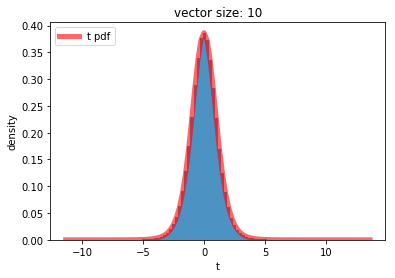

In [56]:
from scipy.stats import t
x = np.linspace(min(cvalues), max(cvalues), 100)
df = size-2
fig = plt.figure()
plt.hist(cvalues, density=True, bins=100, histtype='stepfilled', alpha=0.8)
plt.plot(x, t.pdf(x, df),'r-', lw=5, alpha=0.6, label='t pdf')
plt.xlabel('t')
plt.ylabel('density')
plt.title("vector size: " + str(size))
plt.legend(loc=2)
plt.show()
fig.savefig("tdist" + str(size) + '.png')

In [78]:
c = 0.72
m = 10
df = m-2
tstatistic = tscore(c, df)
pvalor = 2*(1-t.cdf(tstatistic, df))
print('p-valor:', pvalor)

p-valor: 0.019754902647658223


In [70]:
size = 10
s = np.random.normal(0, 1, (2, size))
c, p = pearsonr(s[0], s[1])
print(c,p)
score = tscore(abs(c), size-2)
pvalue = 2*(1-t.cdf(score, size-2))
print(pvalue)

0.20189396891287836 0.5759228387009458
0.5778586079161037


In [59]:
A = [1, 2, 3, 4]
B = [2, 1, 3, 4]
print(spearmanr(A,B))

SpearmanrResult(correlation=0.7999999999999999, pvalue=0.20000000000000007)


In [60]:
A = [70, 100, 83, 59, 89, 71, 59, 52, 97, 54]
P = [160, 195, 175, 150, 184, 172, 159, 177, 191, 158]
print(spearmanr(A,P))

SpearmanrResult(correlation=0.7234075969792768, pvalue=0.018047748354494214)


In [91]:
def pvalor_correlacao_twosided_pareto(vector_size, rho):
    nrows = 5000
    s = np.random.pareto(0.75, (nrows, vector_size))
    c = np.corrcoef(s)
    count = np.sum(abs(c) >= abs(rho))
    total = nrows * nrows
    return count/total, c

In [92]:
size = 10
p, c = pvalor_correlacao_twosided_pareto(size, 0.99)
print("p-valor:", p)

p-valor: 0.00584376


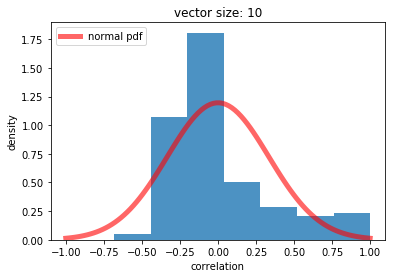

In [93]:
cvalues = c.flatten()
plotCorrHist(cvalues, size)

In [88]:
np.mean(cvalues)

0.00017729990201355202